# Optimizing a Portfolio Using Modern Portfolio Theory

**Credit for some of the code (and virtually all of the knowledge) goes to Jay Chen, his lectures, and his "Python for Finance" book.

## Goal:
The main goal of this project is to use Modern Portfolio Theory, devised by Nobel Prize winning economist Harry Markowitz, to create an optimal portfolio given a list of stocks, ETFs, mutual funds, or a combination of each. The user can input any number of tickers they wish and the program should run seamlessly.

## Define Functions

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import datetime as dt
import seaborn as sns

style.use('ggplot')

# Date range for data collection
start = dt.datetime(2000,1,1)
end = dt.datetime.now()

def place_value(number):
    return ("{:,}".format(number))

# Ask the user to input desired tickers
def get_tickers():
    tickers = []
    while True:
        try:
            stock = str(input('Enter a ticker, press "enter" you are finished: '))
            if stock == '':
                print("Funds have been added")
                break
            else:
                stock = pd.DataFrame(web.DataReader(stock, 'yahoo', start, end)['Adj Close']).rename(columns = {'Adj Close': stock.upper()})
                tickers.append(stock.columns.values[0].upper())
        except Exception:
            print('Enter a valid ticker')
    
    return tickers

# Gather the data
def get_data(tickers, start, end):
    print("Fetching data...")
    data = pd.DataFrame()
    for ticker in tickers:
        data[ticker] = web.DataReader(ticker, 'yahoo', start, end)['Adj Close']

    # Find daily returns, avg. return, and standard deviation
    for i in range(len(tickers)):
        data['return_'+tickers[i]] = data[tickers[i]].pct_change()
        data['stdev_'+tickers[i]] = data['return_'+tickers[i]].std()
        data['mean_'+tickers[i]] = data['return_'+tickers[i]].mean()
        
    data = data.dropna()
    
    return data

# Calculate standard deviation
def calc_sigma(tickers, data):
    stdev = pd.DataFrame()
    for i in range(len(tickers)):
        stdev['stdev_'+tickers[i]] = data['stdev_'+tickers[i]]
    
    stdev = stdev.reset_index(drop = True)
    stdev = stdev[-1:]
    sigma = np.array(stdev)
    sigma = sigma.tolist()
    sigma = sigma[0]
    
    return sigma

# Calculate average return
def calc_mean(tickers, data):
    mean = pd.DataFrame()
    for i in range(len(tickers)):
        mean['mean_'+tickers[i]] = data['mean_'+tickers[i]]

    mean = mean.reset_index(drop = True)
    mean = mean[-1:]
    mean = np.array(mean)
    mean = mean.tolist()
    mean = mean[0]
    
    return mean

# Calculate Rho
def calc_rho(tickers, data):
    ret = pd.DataFrame()
    for i in range(len(tickers)):
        ret['return_'+tickers[i]] = data['return_'+tickers[i]]

    rho = np.cov(ret)
    return rho

# Creates random weights
def xlist(n):
    x = []
    for i in range(n):
        x.append(random.random())
    return [i/sum(x) for i in x]

# Variance-covariance matrix (Credit: Jay Chen)
def covmat(sigma, rho):
    n = len(sigma)
    sigma = np.matrix(sigma)
    sigmatrix = np.dot(np.transpose(sigma), sigma)
    temp = np.ones([n,n])
    for i in range(n):
        j = i + 1
        while j < n:
            temp[i,j] = rho[i][j-i-1]
            j+=1
    rhomatrix = np.multiply(temp, np.transpose(temp))
    varcov = np.multiply(rhomatrix, sigmatrix)
    return varcov

# Define the portfolio (Credit: Jay Chen)
def port(x, mean, sigma, rho):
    port_return = np.dot(x, np.transpose(mean))
    x = np.matrix(x)
    xSig = np.dot(x, covmat(sigma,rho))
    temp = np.dot(xSig,np.transpose(x))
    port_risk = temp.item()**.5
    return [port_return, port_risk]

# Ask user to input the amount they would like to invest
def get_investment():
    while True:
        try:
            invest = float(input("How much money are you investing? "))
            break
        except Exception:
            print("Enter a valid number!")
    
    return invest

# Creates an aesthetically pleasing correlation matrix plot
def corrplot(tickers, data):
    returns = pd.DataFrame()
    for i in range(len(tickers)):
        returns[tickers[i]] = data['return_'+tickers[i]]

    corr = returns.corr()

    fig = plt.subplots(figsize = (10, 8))
    fig = sns.heatmap(
        corr, 
        vmin = -1, vmax = 1, center = 0,
        cmap = sns.diverging_palette(10, 240, n = 256),
        square = True,
        annot = True,
        cbar_kws={'label': 'Correlation'},
        xticklabels = True,
        yticklabels = True
    )

    fig.set_xticklabels(
        fig.get_xticklabels(),
        rotation = 45,
        horizontalalignment = 'right'
    )

    fig.set_yticklabels(
        fig.get_yticklabels(),
        rotation = 0
    )

    plt.title('Correlation Matrix')

    x = plt.show()
    
    return x

# Monte Carlo analysis to find expected return
def mc_analysis(mean, sigma, rho):
    risk = []
    returns = []
    portlist = []
    
    x = 1000000
    futures = "{:,}".format(x)
    
    print(f"Generating {futures} possible futures...")

    for i in range(x):
        allocation = xlist(len(sigma))
        portlist.append(allocation)
        portfolio = port(allocation, mean, sigma, rho)
        risk.append(portfolio[1])
        returns.append(portfolio[0])
        
    return risk, returns, portlist

# Plot the MC results
def mc_plot(risk, returns):
    plt.plot(risk, returns, 'b.')
    plt.title('Efficient Frontier')
    plt.xlabel('Sigma')
    plt.ylabel('Return')
    x = plt.show()
    
    return x

# Find the portfolio with the highest risk-adjusted returns
def optimal_portfolio(risk, returns, portlist):
    portfolio = pd.DataFrame({'Return': returns,
                            'Sigma': risk,
                            'Portfolio': portlist})
    
    portfolio['Sharpe'] = portfolio['Return']/portfolio['Sigma']
    portfolio['Annualized Sharpe'] = portfolio['Sharpe']*252**.5
    portfolio['Annualized Sigma'] = portfolio['Sigma']*252**.5
    portfolio['Annualized Return'] = portfolio['Return']*252
    
    portfolio = portfolio.sort_values(by = 'Sharpe', ascending = False).reset_index(drop = True)
    
    return portfolio

# Output a table showing the allocation of the most optimal portfolio
def best_allocation(data, portfolio, tickers):
    current = pd.DataFrame()
    for i in range(len(tickers)):
        current[tickers[i]] = data[tickers[i]]
        
    current = current[-1:].reset_index(drop = True).transpose().reset_index().rename(columns = {0: 'Current Price',
                                                                                               'index': 'Ticker'})
    best = portfolio['Portfolio'][0]
    best = portfolio.iloc[0,2]
    
    lists = [tickers, best]
    
    df = pd.concat([pd.Series(x) for x in lists], axis = 1)
    df = df.rename(columns = {0: 'Ticker',
                             1: 'Weight (%)'})
    df['Weight (%)'] = round(df['Weight (%)']*100,2)
    df['Investment ($)'] = round(df['Weight (%)']/100*invest,2)
    df['Shares'] = round(df['Investment ($)']/current['Current Price'])
    
    table = pd.merge(current, df, on = 'Ticker')
    table['Current Price'] = round(table['Current Price'], 2)
    
    table = table.sort_values(by = 'Weight (%)', ascending = False)
    
    table = table.style.format({
        'Current Price': '{:,}',
        'Weight (%)': '{:.2f}',
        'Investment ($)': '{:,}',
        'Shares': '{:,}'
    }).hide_index()
    
    return table

# Output Monte Carlo results for: Return, Standard Deviation, and Sharpe Ratio
def portfolio_stats(portfolio):
    print("Calculating potential future value...")
    stats = portfolio.iloc[0,4:7]
    sharpe = stats[0]
    sigma, r = stats[[1, 2]]*100
    stats = print(f"Return: {round(r, 2)}% | Standard Deviation: {round(sigma, 2)}% | Sharpe: {round(sharpe, 2)}")
    
    return stats

# Output the date range of the data that was used in the calculations
def date_range(data):
    dates = data.reset_index(drop = False)
    dates['Date'] = pd.to_datetime(dates['Date'])
    start_date = dates.iloc[0,0].date()
    end_date = dates.iloc[-1,0].date()
    date_range = print(f"Date Range: {start_date} to {end_date}")

    return date_range

In [6]:
tickers = get_tickers()
data = get_data(tickers, start, end)
invest = get_investment()

Enter a ticker, press "enter" you are finished: splg
Enter a ticker, press "enter" you are finished: spyg
Enter a ticker, press "enter" you are finished: spyv
Enter a ticker, press "enter" you are finished: ijr
Enter a ticker, press "enter" you are finished: avuv
Enter a ticker, press "enter" you are finished: avde
Enter a ticker, press "enter" you are finished: vo
Enter a ticker, press "enter" you are finished: 
Funds have been added
Fetching data...
How much money are you investing? 10000


Generating 1,000,000 possible futures...


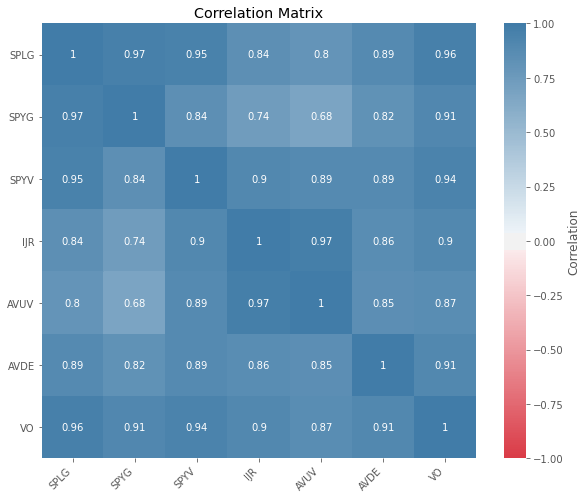

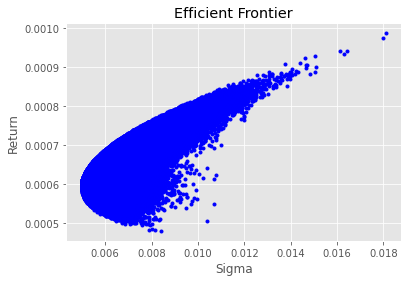

(None, None)

In [7]:
sigma = calc_sigma(tickers, data)
mean = calc_mean(tickers, data)
rho = calc_rho(tickers, data)
risk, returns, portlist = mc_analysis(mean, sigma, rho)
portfolio = optimal_portfolio(risk, returns, portlist)

cor = corrplot(tickers, data)
mc = mc_plot(risk, returns)
best_port = best_allocation(data, portfolio, tickers)

cor, mc

In [8]:
portfolio_stats(portfolio), date_range(data)

Calculating potential future value...
Return: 15.66% | Standard Deviation: 8.04% | Sharpe: 1.95
Date Range: 2019-09-27 to 2021-12-10


(None, None)

In [9]:
best_port

Ticker,Current Price,Weight (%),Investment ($),Shares
SPYG,72.51,20.65,"2,065.0",28.0
SPLG,55.38,19.01,"1,901.0",34.0
VO,250.99,14.98,"1,498.0",6.0
SPYV,41.18,14.89,"1,489.0",36.0
IJR,113.21,12.60,"1,260.0",11.0
AVDE,63.13,10.04,"1,004.0",16.0
AVUV,79.43,7.82,782.0,10.0


In [ ]:
# table.to_csv('/Users/sam/Documents/Portfolio Projects/Stock Comparison/MPT.csv', index = False)